# Imports

In [16]:
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from autoviz.AutoViz_Class import AutoViz_Class
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
from sklearn.decomposition import PCA
seed=1

from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils  import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import tensorflow.keras.backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Data loading

In [3]:
#binary classification
raw_data=pd.read_csv('EMP_Data.csv')

In [4]:
raw_data.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
count,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00",14999,14999
unique,nan,nan,nan,nan,nan,nan,nan,nan,10,3
top,nan,nan,nan,nan,nan,nan,nan,nan,sales,low
freq,nan,nan,nan,nan,nan,nan,nan,nan,4140,7316
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.24,0.02,NaN,NaN
std,0.25,0.17,1.23,49.94,1.46,0.35,0.43,0.14,NaN,NaN
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00,NaN,NaN
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00,NaN,NaN
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00,NaN,NaN
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00,NaN,NaN


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
Department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


# Visuals

In [6]:
# AV = AutoViz_Class()
# filename = ""
# sep = ","
# dft = AV.AutoViz(
#     filename,
#     sep,
#     'left',
#     raw_data,
#     header=0,
#     verbose=1,
#     lowess=False,
#     chart_format="svg",
#     max_rows_analyzed=150000,
#     max_cols_analyzed=30,
# )

In [7]:
raw_data['Department'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: Department, dtype: int64

In [8]:
raw_data['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [9]:
raw_data=pd.get_dummies(raw_data)

In [10]:
raw_data.shape

(14999, 21)

In [12]:
X = raw_data.drop(labels='left', axis=1)
y = raw_data["left"]

In [13]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df=scaler.fit_transform(X)

In [25]:
X.shape

(14999, 20)

In [18]:
# PCA

pca_data = pd.DataFrame([[0, 0, 0]], columns=[
                        'n_components', 'Cumulative_Variance', 'individual_variance'])
for k in range(1, 18):
    pca = PCA(n_components=k,random_state=seed)
    pca.fit(X)
    cum_var = sum(pca.explained_variance_ratio_)
    ind_var = pca.explained_variance_ratio_
    row = pd.DataFrame(data=[[k, cum_var, ind_var]], columns=[
                       'n_components', 'Cumulative_Variance', 'individual_variance'])
    pca_data = pca_data.append(row, ignore_index=True)
pca_data

,n_components,Cumulative_Variance,individual_variance
0,0,0.00,0
1,1,1.00,[0.9979995343193903]
2,2,1.00,"[0.9979995343193893, 0.000869342837545482]"
3,3,1.00,"[0.9979995343193907, 0.0008693428375454804, 0...."
4,4,1.00,"[0.9979995343193903, 0.0008693428375454863, 0...."
5,5,1.00,"[0.9979995343193903, 0.000869342837545486, 0.0..."
6,6,1.00,"[0.9979995343193897, 0.0008693428375454873, 0...."
7,7,1.00,"[0.9979995343193903, 0.000869342837545486, 0.0..."
8,8,1.00,"[0.997999534319391, 0.000869342837545488, 0.00..."
9,9,1.00,"[0.9979995343193903, 0.0008693428375454871, 0...."


In [35]:
# ANN Logistic model
import tensorflow as tf

In [57]:
from tensorflow.keras import Sequential
model = Sequential()

In [58]:
from tensorflow.keras.layers import Dense,Dropout,Activation
tf.keras.backend.clear_session
tf.random.set_seed(100)
model.add(Dense(1,input_shape=(20,),activation='sigmoid'))

model.compile(Adam(lr=0.001), 'binary_crossentropy', metrics=['accuracy'])

Train on 14999 samples
Epoch 1/30
14999/14999 [==============================] - 0s 22us/sample - loss: 11.6827 - accuracy: 0.2381
Epoch 2/30
14999/14999 [==============================] - 0s 21us/sample - loss: 11.6827 - accuracy: 0.2381
Epoch 3/30
14999/14999 [==============================] - 0s 19us/sample - loss: 11.6827 - accuracy: 0.2381
Epoch 4/30
14999/14999 [==============================] - 0s 19us/sample - loss: 11.6827 - accuracy: 0.23810s - loss: 11.5990 - accuracy: 0.2
Epoch 5/30
14999/14999 [==============================] - 0s 20us/sample - loss: 11.6827 - accuracy: 0.2381
Epoch 6/30
14999/14999 [==============================] - 0s 24us/sample - loss: 11.6827 - accuracy: 0.2381
Epoch 7/30
14999/14999 [==============================] - 0s 21us/sample - loss: 11.6827 - accuracy: 0.2381
Epoch 8/30
14999/14999 [==============================] - 0s 23us/sample - loss: 11.6827 - accuracy: 0.2381
Epoch 9/30
14999/14999 [==============================] - 0s 23us/sample - loss

<Figure size 576x432 with 0 Axes>

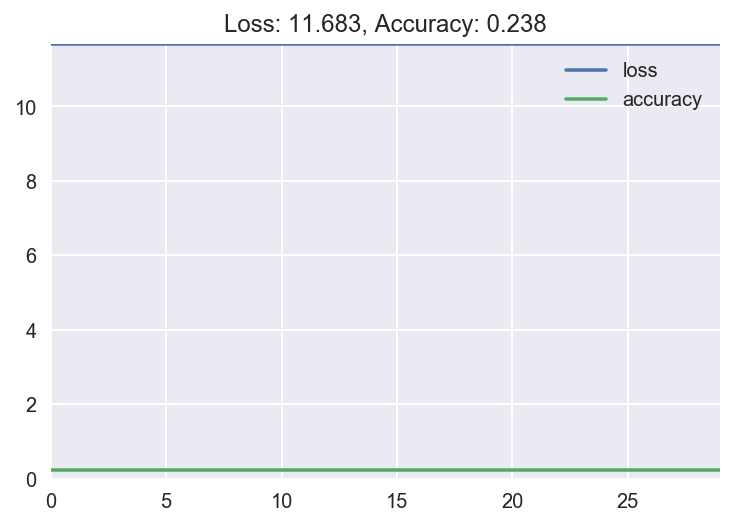

In [59]:
hist = model.fit(X,y,epochs=30,batch_size=100)
plot_loss_accuracy(hist)

<Figure size 576x432 with 0 Axes>

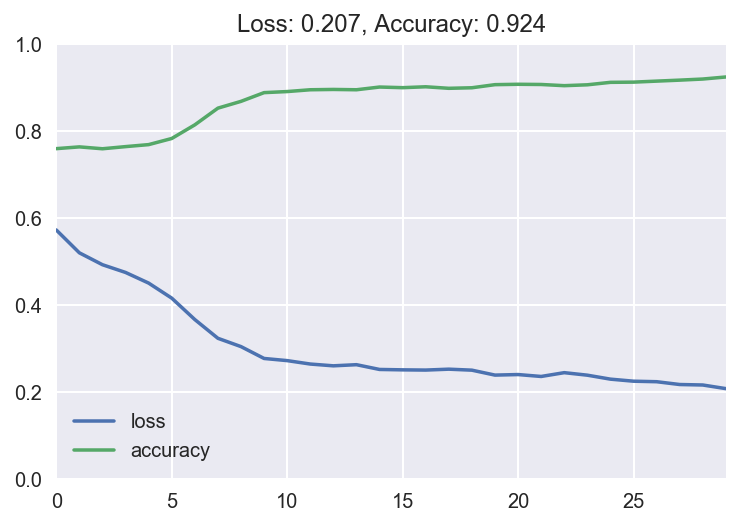

In [64]:
tf.keras.backend.clear_session
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(64,input_shape=(20,),activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(Adam(learning_rate=0.001), 'binary_crossentropy', metrics=['accuracy'])
hist=model.fit(X,y,epochs=30,verbose=0)
plot_loss_accuracy(hist)